# Persistence analysis

En este proyecto se utilizarán herramientas de visualización/exploración de datos: encaje de Takens, complejos simpliciales, homología persistente, diagramas persistentes, códigos de barras, diagramas de densidad e imágenes de persistencia para estudiar una serie de tiempo.

Realizaremos un análisis exploratorio del conjunto de datos proporcionado. El objetivo es comprender y poder explicar los patrones que observa en el conjunto de datos.
Entrega un reporte 

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
import seaborn as sb
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams.update(plt.rcParamsDefault)
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_point_cloud
import plotly.graph_objects as go
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform,pdist
import math
import persim
import tadasets   

sb.set(style="whitegrid")

### Data

In [3]:
headers=['Year','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
datos= pd.read_fwf('nino34.long.anom.data.txt', names=headers)
datos = datos.drop(datos.index[-1])
datos

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2014,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
145,2015,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
146,2016,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
147,2017,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85


### Análisis Exploratorio

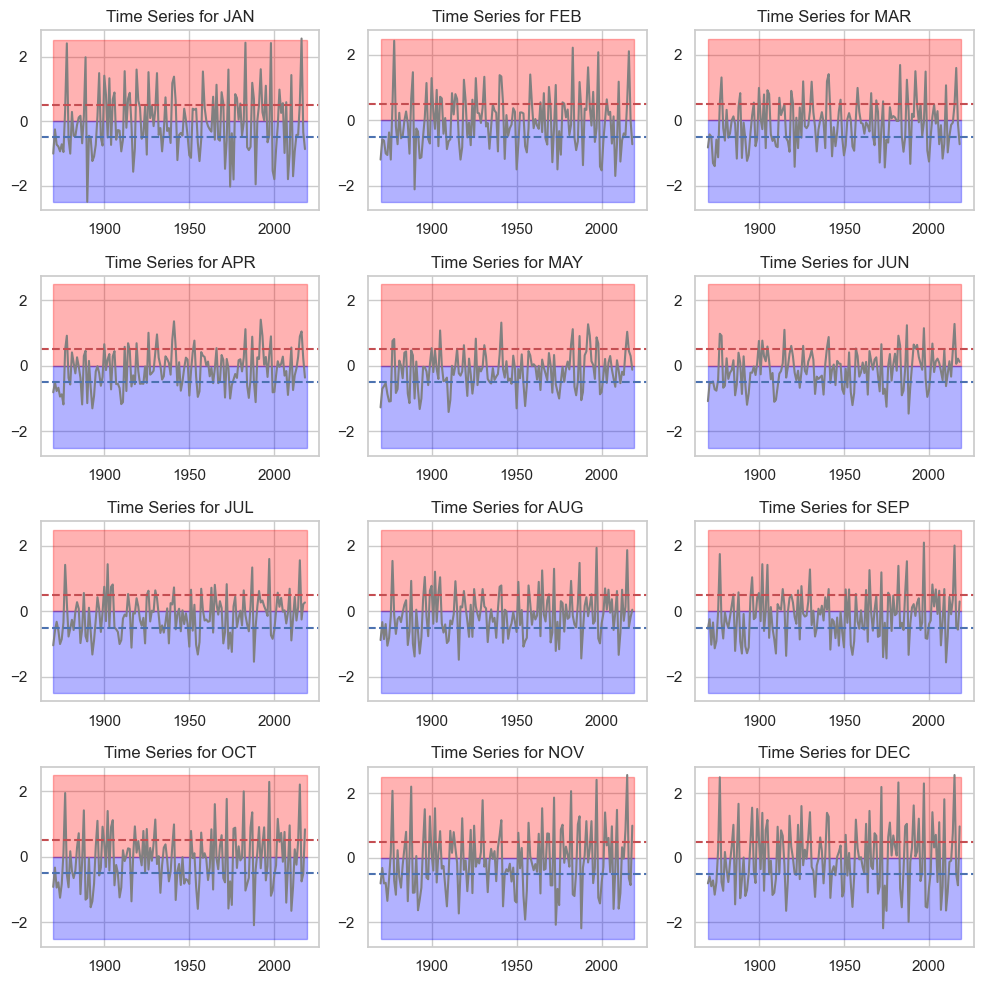

In [4]:


# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows= 4, ncols=3, figsize=(10, 10))
axes = axes.flatten()  # Flatten the array to make indexing easier in a loop
x,y = (datos["Year"],datos.iloc[:,1:])

y_boy =  y[(y >=0.5).any(axis=1)]
y_girl =  y[(y <=0.5).any(axis=1)]




#colors
cmap =  cm.get_cmap('viridis',12) 
# Plot each column
for i,column in enumerate(y.columns):
    color = cmap(i)
    #Agregar colores de fondo
    axes[i].add_patch(patches.Rectangle((1870,0),y.shape[0],2.5,color='red',alpha=0.3)) #color rojo para el Niño
    axes[i].add_patch(patches.Rectangle((1870,0),y.shape[0],-2.5,color='blue',alpha=0.3)) #color rojo para la Nina
    axes[i].plot(x,y[column],marker="",linestyle="-",color="gray")
    axes[i].set_title(f'Time Series for {column}')
    axes[i].axhline(y=0.5, color='r', linestyle='--')
    axes[i].axhline(y=-0.5, color='b', linestyle='--')
    axes[i].grid(True)



# Adjust layout
plt.tight_layout()
plt.show()

### Encaje de Takens

Esta técnica es utilizada en funciones de serie de tiempo para **comprobar si son periodicas con el tiempo**. Mas formalemente, si tenemos una serie de tiempo $f(t)$ la cual tenemos discretizada (un tamaño k de pesa por cada zancada).

$$f(t) = f(t_1),f(t_1 + k),f(t_1 + 2k),...,f(t_1 + nk)$$

Donde:

$$k = t_{i+1} - t_i$$

Dado lo anterior, podemos encajar nuestros datos en un espacio de dimension d. Para esto, consideramos para cada i un delay de tiempo $\tau$:

$$F(t_i) = (f(t_i),f(t_i + \tau),...,f(t_i +  (d - 1)\tau))$$

* $f(t_i)$ se llama **inicio de la ventana**
* $f(t_i + (d-1)\tau)$ se llama **final de la ventana**

#### Teorema de Florin Takens

Si se escogen bien los parámetros $(\tau,d)$ para una señal discretizada $f(t)$ con valores en los reales $(ℝ,t)$ entonces la función:

$$Tf_{τ,d}:ℝ \to ℝ$$

Esta misma está definida por $Tf_{τ,d}(t) = (f(t_i),f(t_i + \tau),...,f(t_i +  (d - 1)\tau))$, el cual es un  **difeomorfismo**


La promesa del teorema del encaje de Takens es que si los datos son periódicos entonces la imagen del encaje forma una elipse, esto es:
$$β_0 =  β_1 = 1$$
$$β_n = 0,∀n > 1$$

Es decir, que la transformacion que se le aplique a nuestra serie de tiempo, tiene que retornar una matriz en el espacio euclediano $ℝ^2$ que sean las coordenadas que formen a un **cículo (elipse)** 

Sin embargo, tenemos que obtener los valores óptimos para $\tau$ y $d$,¿cuáles serían?

In [5]:
parametros_optimos = pd.DataFrame(columns = ["column","tau","d"])
parametros_optimos

,column,tau,d


In [6]:
#La parte real de la raiz de la cantidad de datos (probamos otros datos)
max_periodic_dimension = 11
max_periodic_time_delay = 11
stride = 1
parametros_optimos = pd.DataFrame(columns = ["column","tau","d"])

for i,column in enumerate(y.columns):
    tau,d= takens_embedding_optimal_parameters(y[column], max_periodic_dimension, max_periodic_time_delay, stride)
    #print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)
    #print("<----------------------->")
    parametros_optimos.loc[i] = [column,tau,d]
    
parametros_optimos

,column,tau,d
0,JAN,2,4
1,FEB,2,5
2,MAR,11,4
3,APR,10,5
4,MAY,9,4
5,JUN,3,4
6,JUL,4,5
7,AUG,1,4
8,SEP,6,4
9,OCT,4,4


In [7]:
#Ejemplo de Encaje de Takens con libreria giotto-tda para el mes de Enero
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(y["JAN"])
print("El delay encontrado es ", embedder_periodic.time_delay_)
print("La dimension encontrada es ", embedder_periodic.dimension_)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

El delay encontrado es  2
La dimension encontrada es  4
Shape of embedded time series: (143, 4)


El algoritmo de giotto-tda nos da como resultado que los parámetros de $τ$ y la dimension. Sin embargo, estos no son necesariamente los parámetros óptimos para el Encaje de Takens.

Si modificamos el stride, estos parámetros cambiarán. Trataremos de buscar los parámetros óptimos


In [8]:
def find_optimal_delay(x, maxtau=50):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)
    return int(np.where(diffmi > 0)[0][0]) #returns the first element in which the difference is greater than 0. It means that gives you the local optimal
    #print(np.where(diffmi > 0))

In [9]:
def find_optimal_dimension(y,tau,maxdim=30):
    dim =  np.arange(1,20)
    f1, f2, f3 = dimension.fnn(y, tau=2, dim=dim)
    diff_f1 = np.diff(f1)
    #print(f1)
    optimal_d = int(np.where(diff_f1 == 0)[0][0]) - 1

    #changeOf_diff_f1 = np.diff(diff_f1) 
    #optimal_dimension = np.argmax(changeOf_diff_f1) + 2
    return optimal_d


In [10]:
def parametros_optimos(meses):
    """
    La funcion nos proporciona los valores optimos tau y dimension
    """
    delays_optimos = []
    dimensiones_optimas = []
    for mes in meses.columns:
        tau =  find_optimal_delay(meses[mes],maxtau=30)
        d = find_optimal_dimension(meses[mes],tau,maxdim=30)
        delays_optimos.append(tau)
        dimensiones_optimas.append(d)

    parametros_optimos = pd.DataFrame({
        "Mes": meses.columns,
        "Tau Optimo": delays_optimos,
        "Dimension optima": dimensiones_optimas ,
    })


    return parametros_optimos

In [11]:
parametros_optimos_meses =  parametros_optimos(y)
parametros_optimos_meses

,Mes,Tau Optimo,Dimension optima
0,JAN,2,2
1,FEB,1,3
2,MAR,2,3
3,APR,2,2
4,MAY,2,2
5,JUN,2,2
6,JUL,4,3
7,AUG,1,2
8,SEP,1,2
9,OCT,2,2


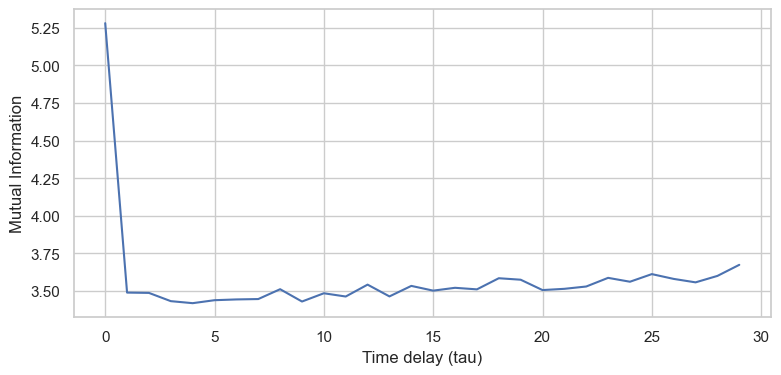

In [12]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information')
plt.plot(delay.dmi(y["JUL"], maxtau=30))
plt.show()

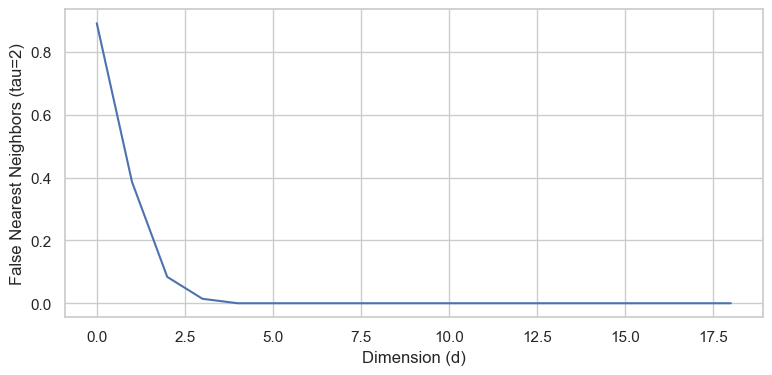

In [13]:
dim = np.arange(1, 20)
f1, f2, f3 = dimension.fnn(y["JUL"], tau=2, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=2)')
plt.plot(f1)

plt.show()

In [14]:
embedding_dimension_periodic = 3
embedding_time_delay_periodic = 4
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y["DEC"])
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (141, 3)


Ahora que tenemos esa grafica, ¿podemos decir que es un circulo?

Ahora que tenemos los valores óptimos para los parámetros de la serie, veremos como se ven los **diagramas de persistencia** con los valores obtenidos para cada mes.

### Homología persistente y análisis de Persistencia

La idea principal detrás de la homología persistente es, dada la filtración de complejos simpliciales (Rips o Alpha), calcular los grupos de homología de cada complejo simplicial y estudiar cómo cambian a lo largo de la filtración. Conforme nuestro parametro $r$ crece, los complejos simpliciales se van haciendo más grandes y, por tanto, los grupos de homología pueden cambiar y las propiedades topológicas de estos espacios topológicos pueden "nacer" o "morir", indicando que hay una característica topológica que aparece o desaparece en el espacio topológico a cierto valor de $r$.

Intuitivamente:

Componentes conexas: https://gjkoplik.github.io/pers-hom-examples/0d_pers_2d_data_widget.html

Hoyo de dimensión 1: https://gjkoplik.github.io/pers-hom-examples/1d_pers_2d_data_widget.html 

Ambos: https://www.geogebra.org/m/muwz8vgx

#### Gudhi Ripser para el encaje de Takens en dos dimensiones

In [15]:

def encaje_takens(y,embedding_time_delay_periodic,embedding_dimension_periodic,stride=1):

    embedder_periodic = SingleTakensEmbedding(
        parameters_type="fixed",
        n_jobs=2,
        time_delay=embedding_time_delay_periodic,
        dimension=embedding_dimension_periodic,
        stride=stride,
    )

    y_periodic_embedded = embedder_periodic.fit_transform(y)
    return y_periodic_embedded

usetex mode requires TeX.


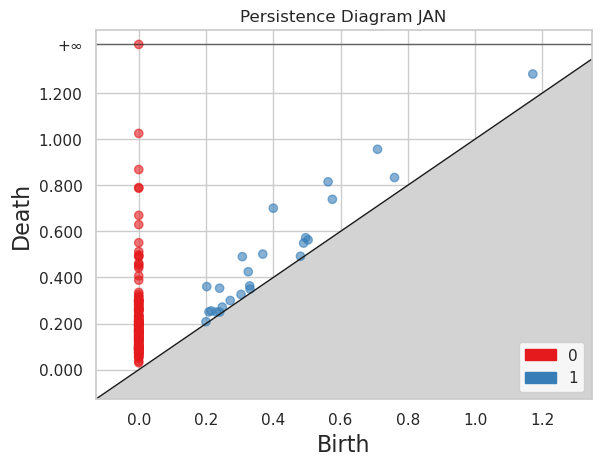

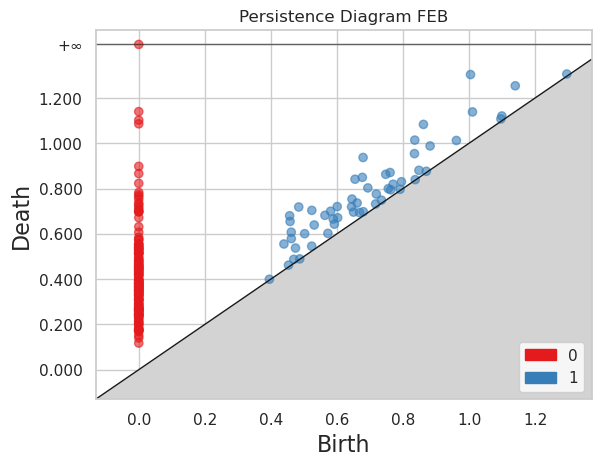

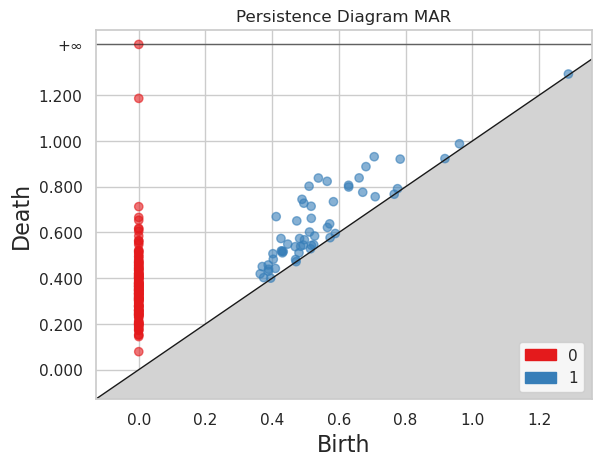

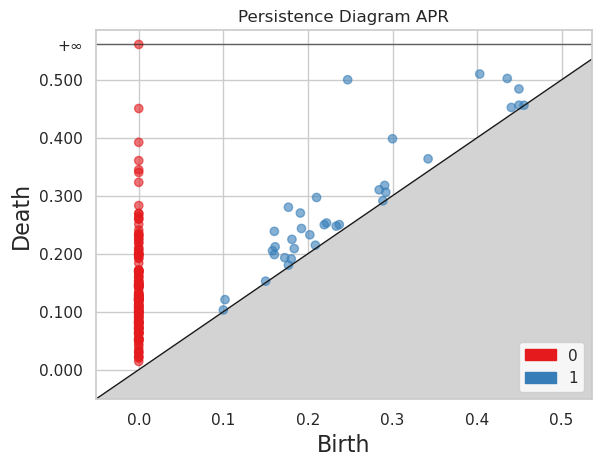

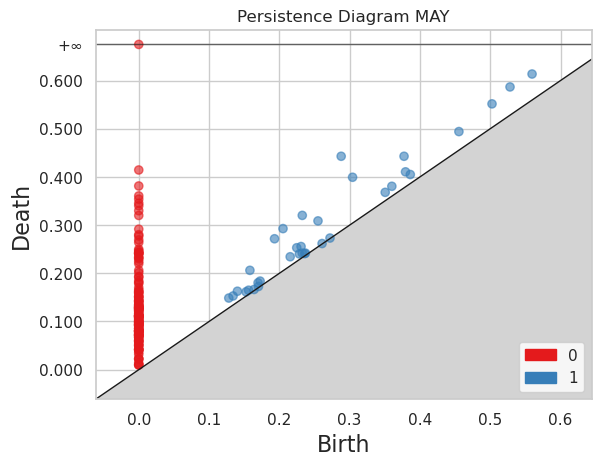

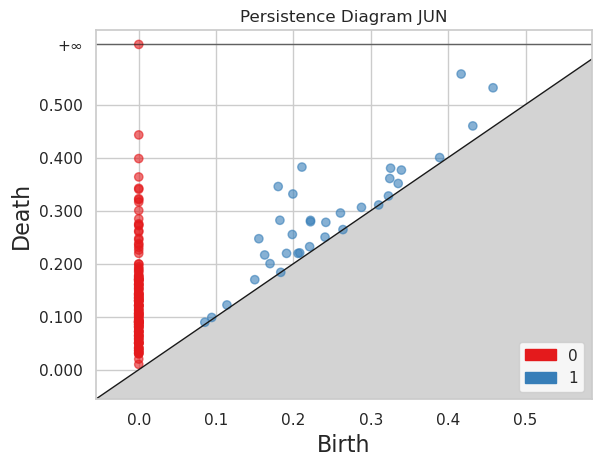

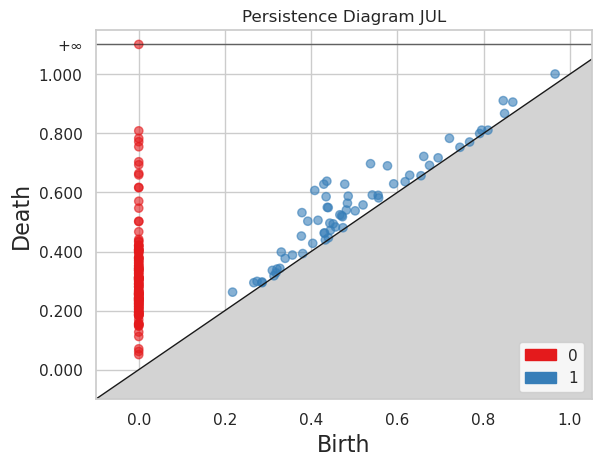

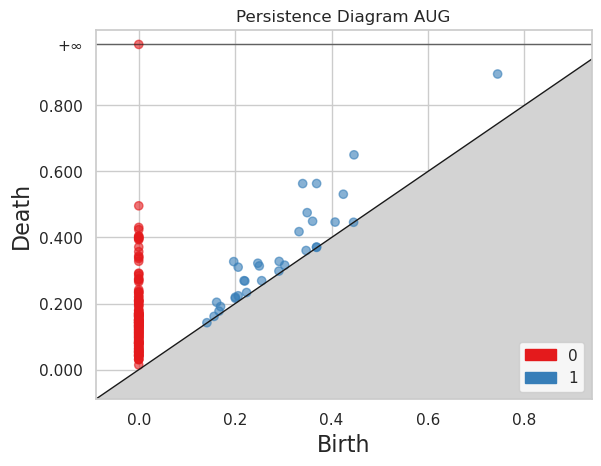

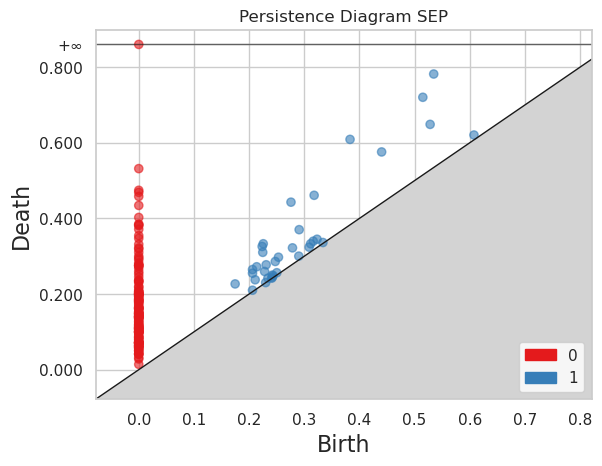

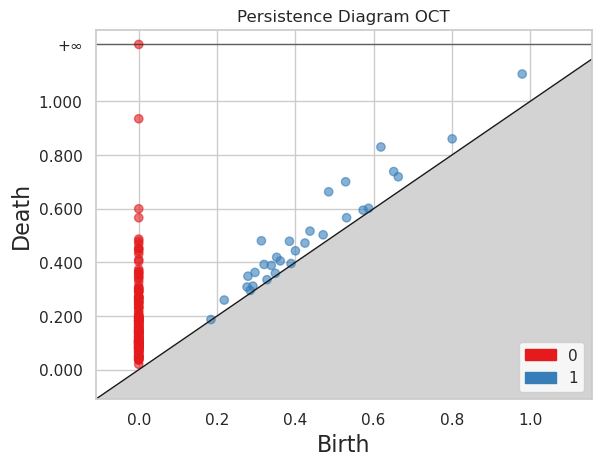

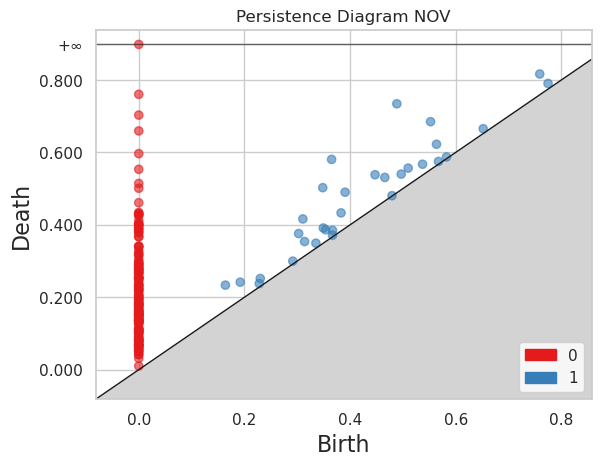

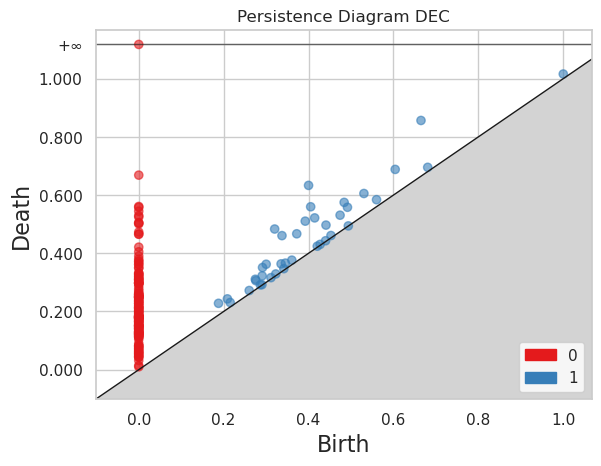

In [16]:
for i,column in enumerate(y.columns):
    y_transformed = encaje_takens(y[column],int(parametros_optimos_meses.loc[i][1]),int(parametros_optimos_meses.loc[i][2]),stride=1)
    skeletonCirc=gd.RipsComplex(points=y_transformed, max_edge_length = 2)
    Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
    Barcodes_Rips_Circ = Rips_simplex_tree_Circ.persistence()
    gd.plot_persistence_diagram(Barcodes_Rips_Circ);
    plt.title(f'Persistence Diagram {column}')
    plt.show()

En base al digrama de persistencia que se muestra, se puede ver que dentro de los puntos rojos (los cuales representan las componentes conexas de los datos del encaje de Takens del mes de enero), persiste uno a la medida que $r$ crece, por lo que podemos inferir que los datos tienen una sola componente conexa. Es decir, $B_0=1$. Por otro lado, para el caso de los puntos azules que representan a $B_1$, parece ser que un punto persiste, sin embargo, no podemos decir a detalle si es significativo

A simple vista con ese diagrama no se puede ver si la transformacion de los datos tienen las mismas propiedades topoligicas de un circulo, sin embargo, trataremos con otras visualizaciones. Sin embargo, a simple vista se pudiera decir que el mes de **Abril** y **Agosto** prometen ser los que pudieran tener una periodicidad

### Codigos de barras

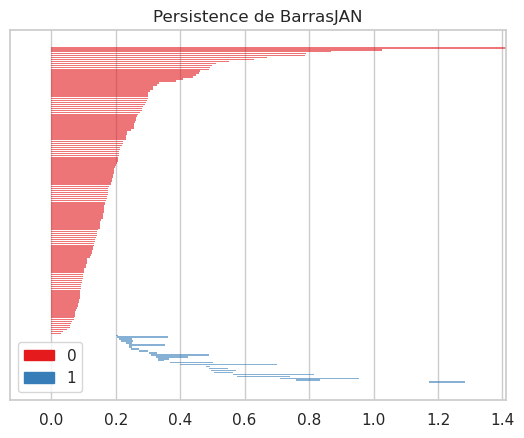

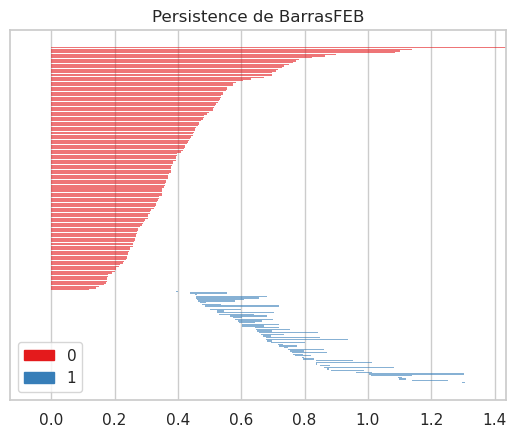

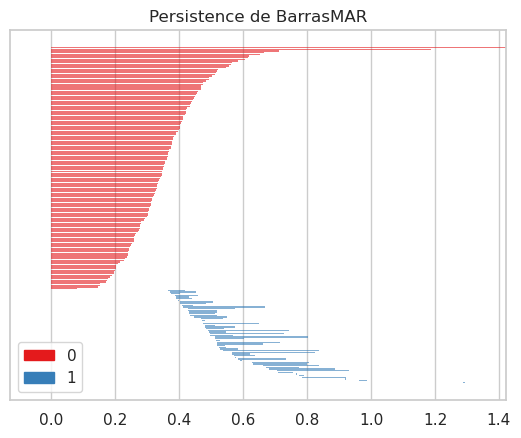

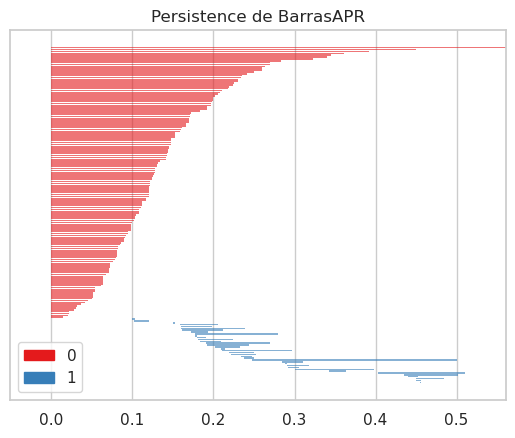

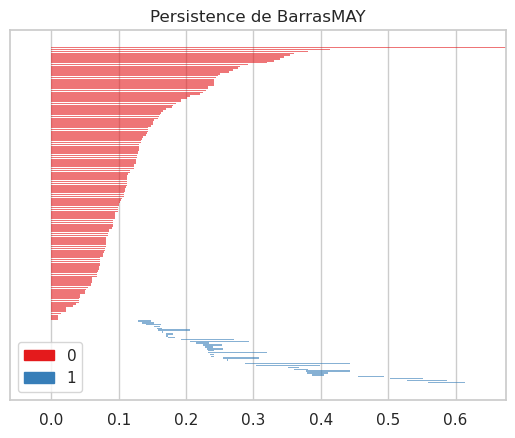

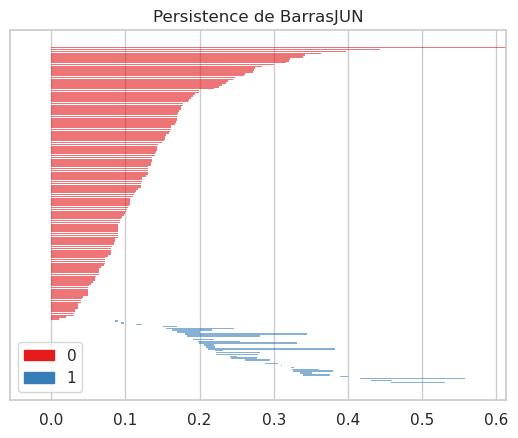

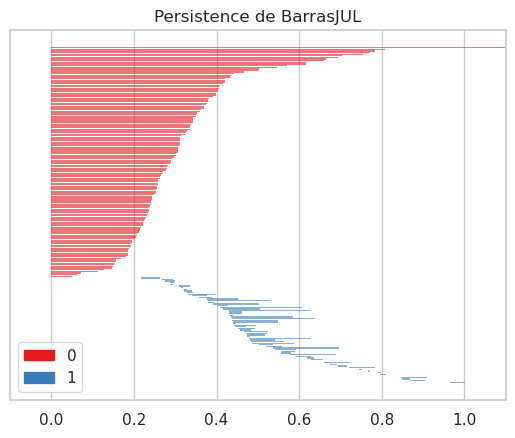

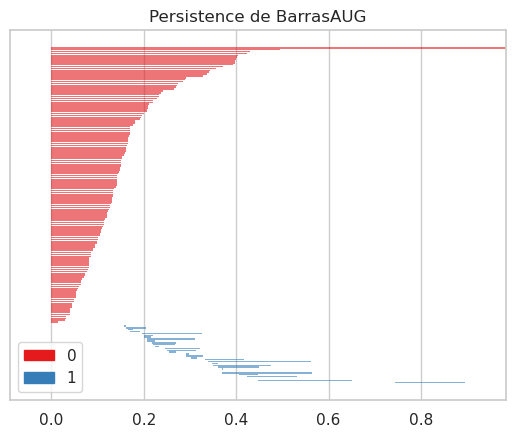

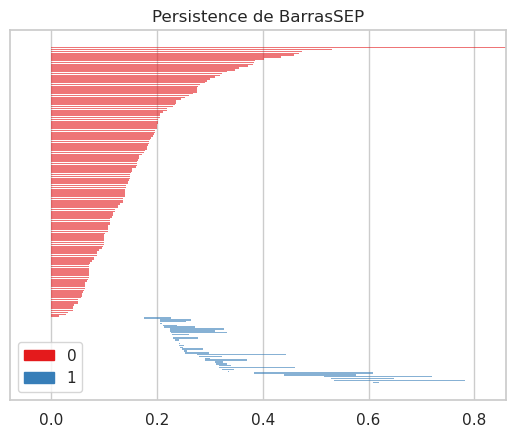

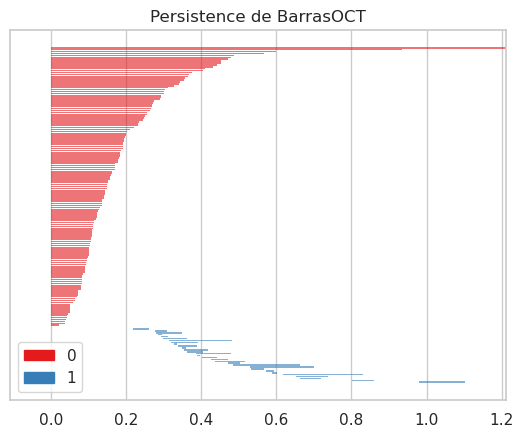

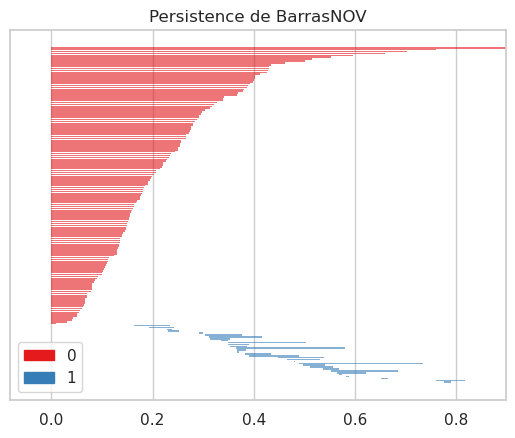

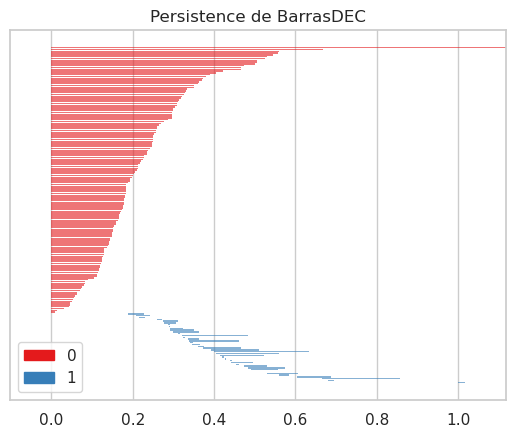

In [17]:
for i,column in enumerate(y.columns):
    y_transformed = encaje_takens(y[column],int(parametros_optimos_meses.loc[i][1]),int(parametros_optimos_meses.loc[i][2]),stride=1)
    skeletonCirc=gd.RipsComplex(points=y_transformed, max_edge_length = 2)
    Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
    diag_inf = Rips_simplex_tree_Circ.persistence(min_persistence=0)
    gd.plot_persistence_barcode(diag_inf);
    plt.title(f'Persistence de Barras{column}')
    plt.show()

### Diagramas de densidad

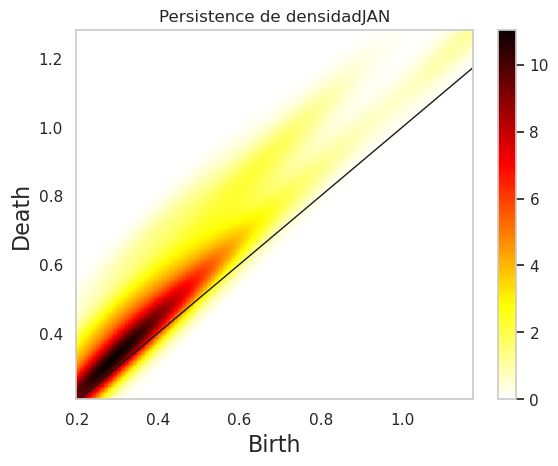

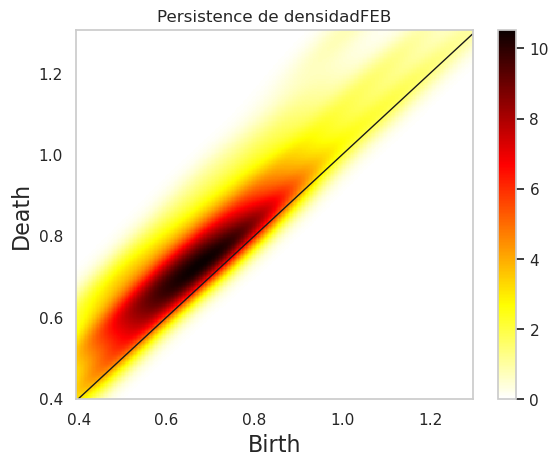

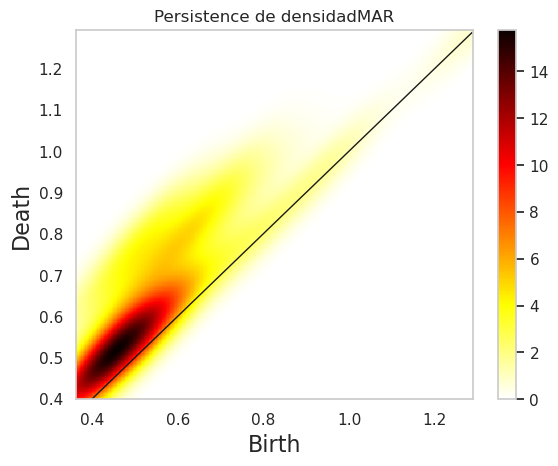

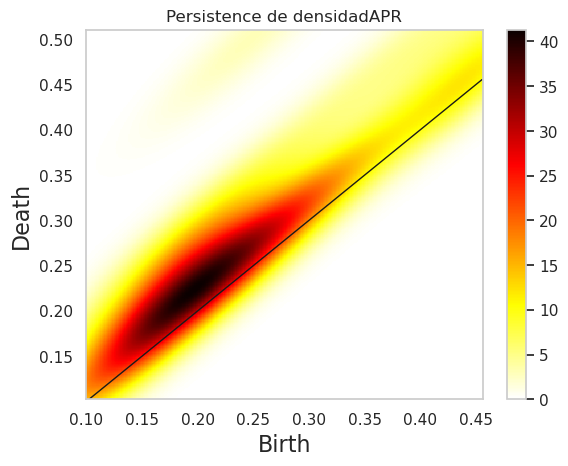

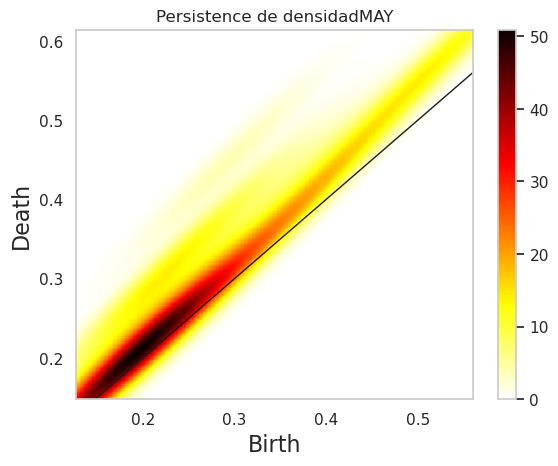

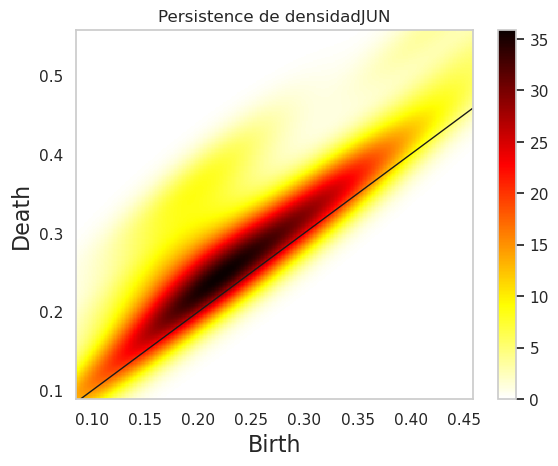

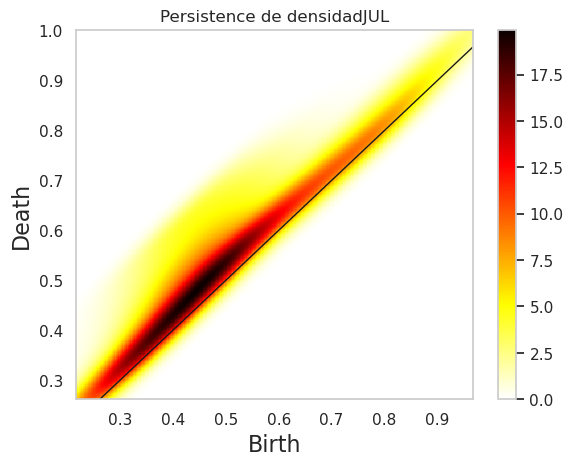

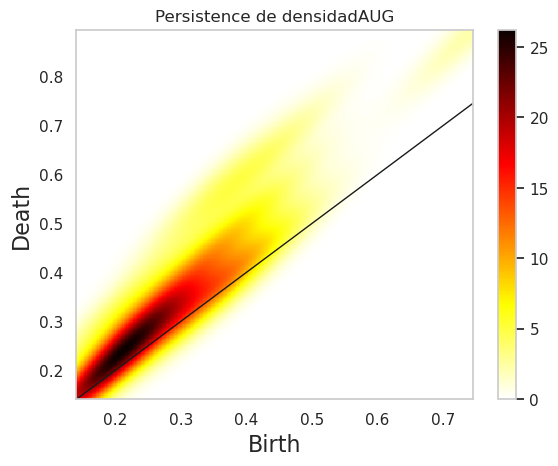

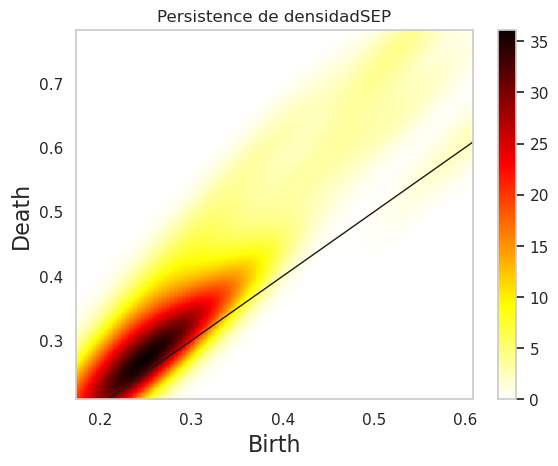

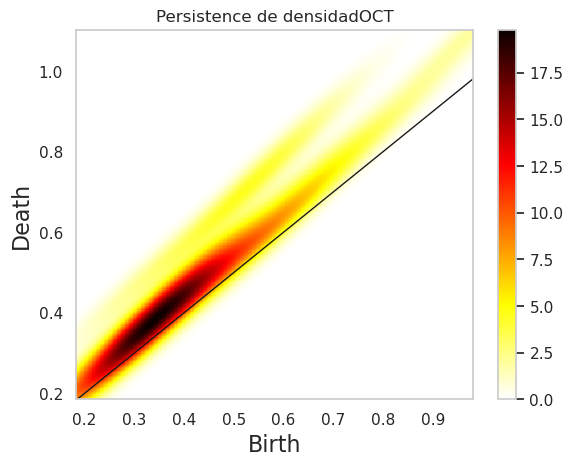

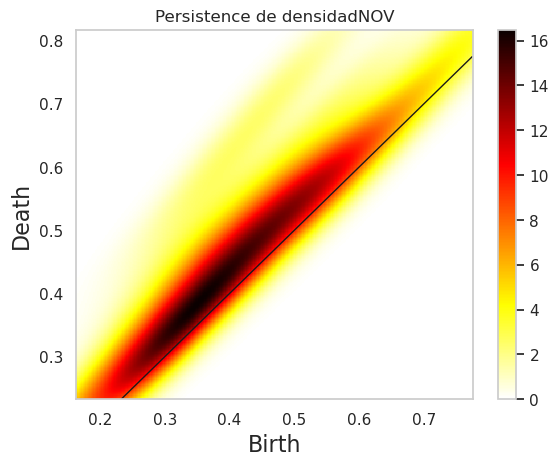

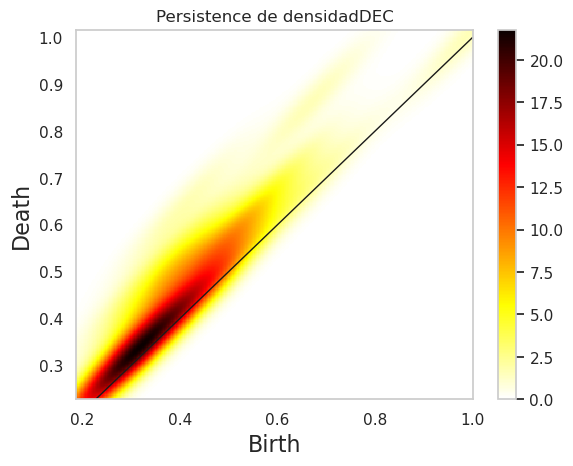

In [18]:
for i,column in enumerate(y.columns):
    y_transformed = encaje_takens(y[column],int(parametros_optimos_meses.loc[i][1]),int(parametros_optimos_meses.loc[i][2]),stride=1)
    skeletonCirc=gd.RipsComplex(points=y_transformed, max_edge_length = 2)
    Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
    diag_inf = Rips_simplex_tree_Circ.persistence(min_persistence=0)
    gd.plot_persistence_density(diag_inf, legend=True, max_intervals=1000, dimension=1);
    plt.title(f'Persistence de densidad{column}')
    plt.show()

De los que podemos observar, en base al diagrama de Barras y de Densidad, es que los meses de **Abril** y **Septiembre** sus puntos persistentes mas tiempo cuando $r$ incrementa. Vamos a ver como se ven las transformaciones de estos datos

In [19]:
#Abril
embedding_dimension_periodic = int(parametros_optimos_meses.loc[3][2])
embedding_time_delay_periodic = int(parametros_optimos_meses.loc[3][1])
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y["APR"])
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (147, 2)


In [20]:
#Mayo
embedding_dimension_periodic = int(parametros_optimos_meses.loc[7][2])
embedding_time_delay_periodic = int(parametros_optimos_meses.loc[7][1])
stride = 1
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(y["APR"])
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")
plot_point_cloud(y_periodic_embedded)

Shape of embedded time series: (148, 2)


## Desde otro enfoque

In [21]:
datos

,Year,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,2014,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
145,2015,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
146,2016,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
147,2017,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85


In [22]:
temperatura = datos.iloc[:, 1:].values.flatten()
temperatura

array([-1.  , -1.2 , -0.83, ...,  0.84,  1.  ,  0.97])

In [23]:
# Extrae la variación de temperatura y el tiempo
temperatura = y.values.flatten()
#temperatura2 = df.iloc[1:60,1:].values.flatten()
tiempo = datos["Year"]

# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura.shape[0])], 
    y=temperatura, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Variación de temperatura a lo largo del tiempo',
    xaxis=dict(title='Periodo'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

Ahora que tenemos los datos agrupados de los las medias moviles de ENSO con una ventana temporal de 5 meses,¿los datos registrados de 1870 al 2018 serán cíclicos?   

In [24]:
parametros_optimos_total = parametros_optimos(pd.DataFrame(temperatura)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_total

,Mes,Tau Optimo,Dimension optima
0,0,9,4


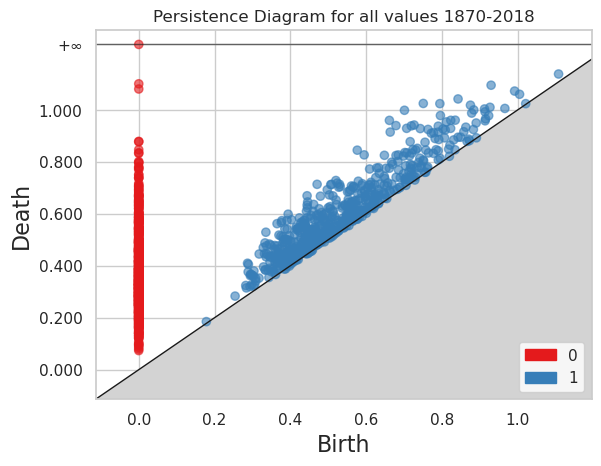

In [25]:

y_transformed = encaje_takens(pd.Series(temperatura),int(parametros_optimos_total.loc[0][1]),int(parametros_optimos_total.loc[0][2]),stride=2)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_Circ = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_Circ);
plt.title(f'Persistence Diagram for all values 1870-2018')
plt.show()

En base al analisis de persistencia del encaje de taken con los valores optimos determinados para los valores totales, no podemos decir que las temperaturas de ENSO tiene una periodicidad en los años de 1870 a 2018. Sin embargo, ¿Será que es para todos los periodos? 

In [26]:
temperatura.shape

(1788,)

In [27]:
temperatura_periodo1 =  temperatura[:298]
temperatura_periodo2 =  temperatura[298:596]
temperatura_periodo3 =  temperatura[596:894]
temperatura_periodo4 =  temperatura[894:1192]
temperatura_periodo5 =  temperatura[1192:1490]
temperatura_periodo6 =  temperatura[1490:]


### Periodo 1

In [28]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura_periodo1.shape[0])], 
    y=temperatura_periodo1, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 1',
    xaxis=dict(title='Mes'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

In [29]:
parametros_optimos_periodo1 = parametros_optimos(pd.DataFrame(temperatura_periodo1)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_periodo1

,Mes,Tau Optimo,Dimension optima
0,0,2,3


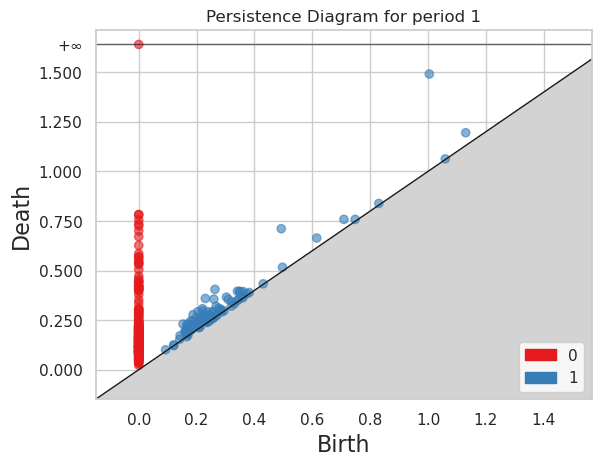

In [30]:

y_transformed = encaje_takens(pd.Series(temperatura_periodo1),int(parametros_optimos_periodo1.loc[0][1]),int(parametros_optimos_periodo1.loc[0][2]),stride=1)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_periodo1 = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_periodo1);
plt.title(f'Persistence Diagram for period 1')
plt.show()

### Periodo 2

In [31]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura_periodo2.shape[0])], 
    y=temperatura_periodo2, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura',
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 2',
    xaxis=dict(title='Mes'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

In [32]:
parametros_optimos_periodo2 = parametros_optimos(pd.DataFrame(temperatura_periodo2)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_periodo2

,Mes,Tau Optimo,Dimension optima
0,0,3,2


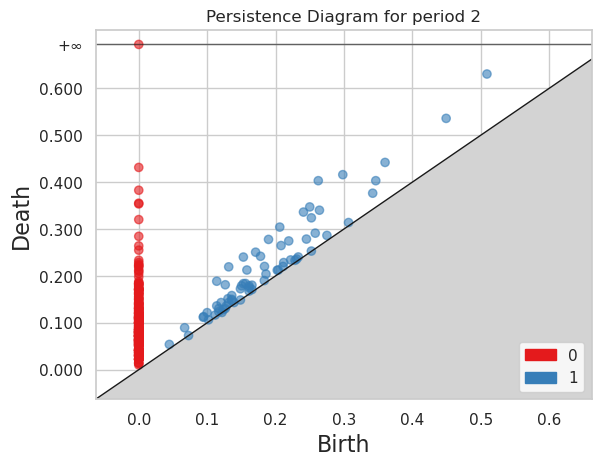

In [33]:

y_transformed = encaje_takens(pd.Series(temperatura_periodo2),int(parametros_optimos_periodo2.loc[0][1]),int(parametros_optimos_periodo2.loc[0][2]),stride=1)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_periodo2 = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_periodo2);
plt.title(f'Persistence Diagram for period 2')
plt.show()

### Periodo 3

In [34]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura_periodo3.shape[0])], 
    y=temperatura_periodo3, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 3',
    xaxis=dict(title='Mes'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

In [35]:
parametros_optimos_periodo3 = parametros_optimos(pd.DataFrame(temperatura_periodo3)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_periodo3

,Mes,Tau Optimo,Dimension optima
0,0,5,3


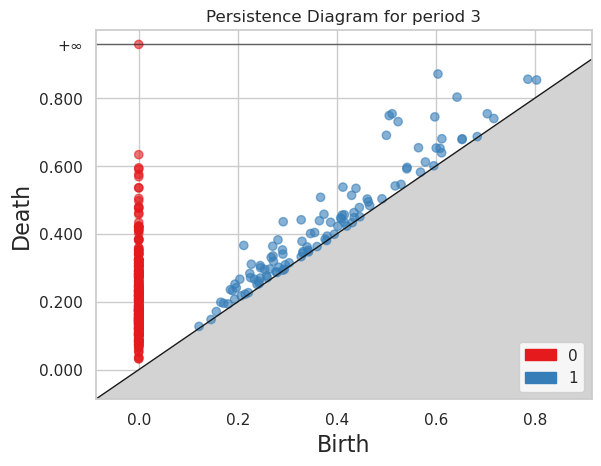

In [36]:
y_transformed = encaje_takens(pd.Series(temperatura_periodo3),int(parametros_optimos_periodo3.loc[0][1]),int(parametros_optimos_periodo3.loc[0][2]),stride=1)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_periodo3 = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_periodo3);
plt.title(f'Persistence Diagram for period 3')
plt.show()

### Periodo 4

In [37]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura_periodo4.shape[0])], 
    y=temperatura_periodo4, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 4',
    xaxis=dict(title='Mes'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

In [38]:
parametros_optimos_periodo4 = parametros_optimos(pd.DataFrame(temperatura_periodo4)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_periodo4

,Mes,Tau Optimo,Dimension optima
0,0,4,4


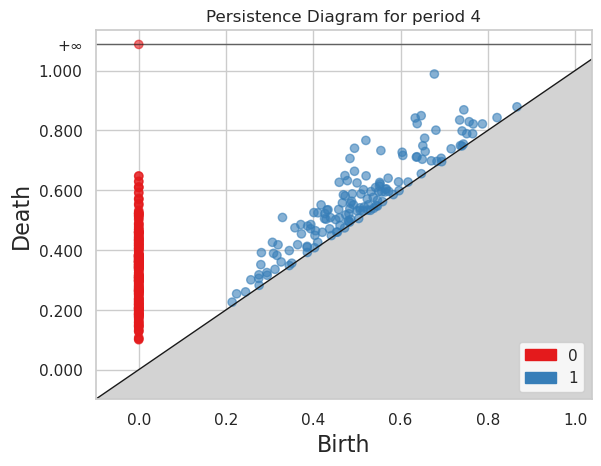

In [39]:
y_transformed = encaje_takens(pd.Series(temperatura_periodo4),int(parametros_optimos_periodo4.loc[0][1]),int(parametros_optimos_periodo4.loc[0][2]),stride=1)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_periodo4 = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_periodo4);
plt.title(f'Persistence Diagram for period 4')
plt.show()

### Periodo 5

In [40]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura_periodo5.shape[0])], 
    y=temperatura_periodo5, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 5',
    xaxis=dict(title='Mes'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

In [41]:
parametros_optimos_periodo5 = parametros_optimos(pd.DataFrame(temperatura_periodo5)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_periodo5

,Mes,Tau Optimo,Dimension optima
0,0,4,3


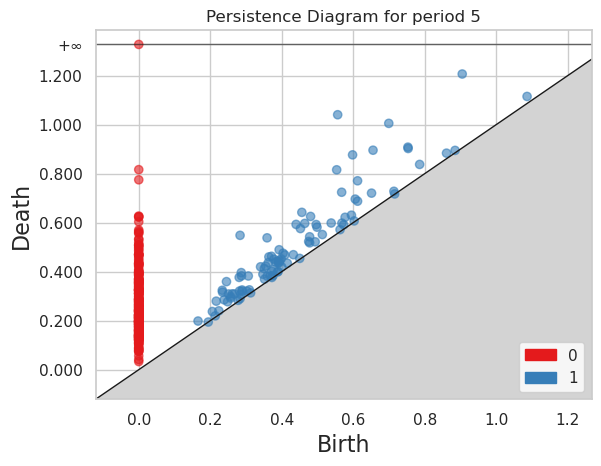

In [42]:
y_transformed = encaje_takens(pd.Series(temperatura_periodo5),int(parametros_optimos_periodo5.loc[0][1]),int(parametros_optimos_periodo5.loc[0][2]),stride=1)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_periodo5 = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_periodo5);
plt.title(f'Persistence Diagram for period 5')
plt.show()

### Periodo 6

In [43]:
# Crea la figura
fig = go.Figure()

# Añade el gráfico de dispersión
fig.add_trace(go.Scatter(
    x=[int(i) for i in range(temperatura_periodo5.shape[0])], 
    y=temperatura_periodo6, 
    mode='markers', 
    marker=dict(size=3),
    name='Variación de temperatura'
))

# Configura el diseño de la figura
fig.update_layout(
    title='Periodo 6',
    xaxis=dict(title='Mes'),
    yaxis=dict(title='Variación de temperatura')
)

# Muestra la figura
fig.show()

In [44]:
parametros_optimos_periodo6 = parametros_optimos(pd.DataFrame(temperatura_periodo6)) #Parametros optimos para todos los valores de 1870 a 2018
parametros_optimos_periodo6

,Mes,Tau Optimo,Dimension optima
0,0,4,2


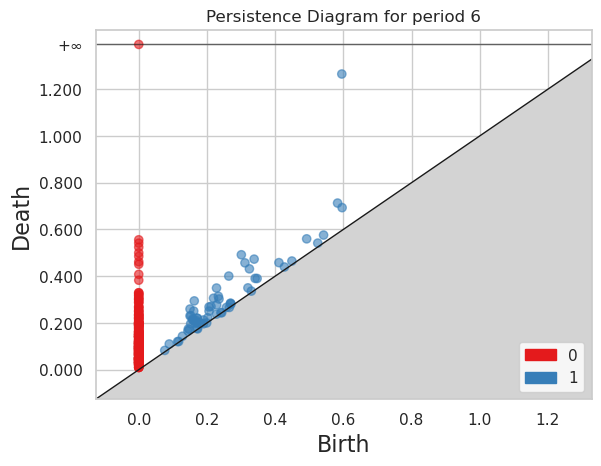

In [45]:
y_transformed = encaje_takens(pd.Series(temperatura_periodo6),int(parametros_optimos_periodo6.loc[0][1]),int(parametros_optimos_periodo6.loc[0][2]),stride=1)
skeletonCirc= gd.RipsComplex(points=y_transformed, max_edge_length = 2)
Rips_simplex_tree_Circ = skeletonCirc.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_periodo6 = Rips_simplex_tree_Circ.persistence()
gd.plot_persistence_diagram(Barcodes_Rips_periodo6);
plt.title(f'Persistence Diagram for period 6')
plt.show()

In [69]:
plot_point_cloud(y_transformed)

En base a lo anterior, observamos que los periodos donde se puede inferir que tuvieron periodicidad son el primero y el sexto periodo.

* **Periodo 1**: 1870 --> 1895
* **Periodo 6**: 1993 --> 2018

Sin embargo, estos dos periodos, ¿qué tan parecidos son de los otros 4 ?

### Comparación de periodos con la metrica de distancia de Bottleneck

Veremos primero que tanto se parecen el periodo 1 y 6

In [49]:
persistence1=np.array([Barcodes_Rips_periodo1[i][1] for i in range(len(Barcodes_Rips_periodo1))])
persistence2=np.array([Barcodes_Rips_periodo2[i][1] for i in range(len(Barcodes_Rips_periodo2))])
persistence3=np.array([Barcodes_Rips_periodo3[i][1] for i in range(len(Barcodes_Rips_periodo3))])
persistence4=np.array([Barcodes_Rips_periodo4[i][1] for i in range(len(Barcodes_Rips_periodo4))])
persistence5=np.array([Barcodes_Rips_periodo5[i][1] for i in range(len(Barcodes_Rips_periodo5))])
persistence6=np.array([Barcodes_Rips_periodo6[i][1] for i in range(len(Barcodes_Rips_periodo6))])
gd.bottleneck_distance(persistence1, persistence6)

0.3347140334144876

In [68]:
#Usar como pivote el periodo6
gd.bottleneck_distance(persistence2, persistence6,e=0)

0.3347140334144876

In [51]:
gd.bottleneck_distance(persistence3, persistence6)

0.3347140334144876

In [52]:
gd.bottleneck_distance(persistence4, persistence6)

0.27652854702245755

In [53]:
gd.bottleneck_distance(persistence5, persistence6)

0.26051299751848245

In [55]:
#Usar al periodo 1 como pivote
gd.bottleneck_distance(persistence1, persistence2)

0.3601388621073822

In [56]:
gd.bottleneck_distance(persistence1, persistence3)

0.2432912372077618

In [57]:
gd.bottleneck_distance(persistence1, persistence4)

0.2432912372077618

In [58]:
gd.bottleneck_distance(persistence1, persistence5)

0.2432912372077618

In [59]:
gd.bottleneck_distance(persistence1, persistence6)

0.3347140334144876

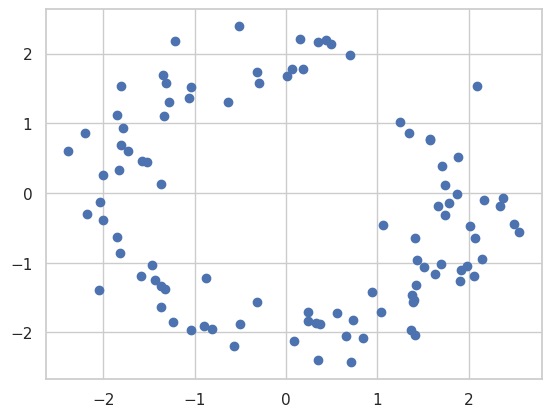

In [60]:
np.random.seed(2879) #puedes cambiar de semilla aleatoria a voluntad
datos_Circunferencia = tadasets.dsphere(d=1,n=100, r=2, noise=0.3) #esta es una esfera de dimensión d=1 en el plano, radio 1 y en la cual se tomaron "aleatoriamente" 1000 puntos.
plt.scatter(datos_Circunferencia[:, 0], datos_Circunferencia[:, 1])
plt.show()

Longitud del Vector de Persistencias:  111


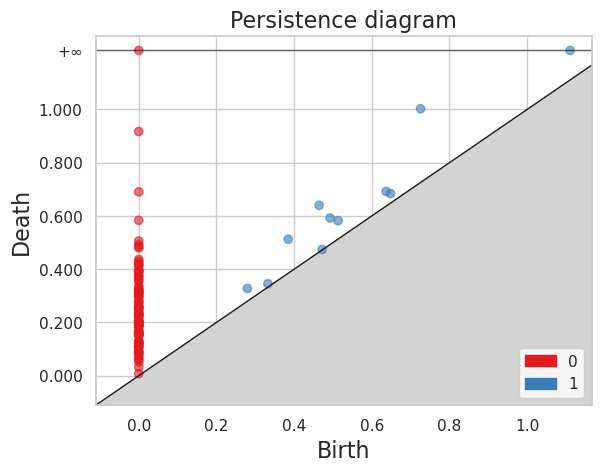

In [61]:
skeleton_circ_1=gd.RipsComplex(
    points=datos_Circunferencia, 
    max_edge_length = 2
) 

# Aquí vamos a pedir que nuestra complejo sea máximo de dimensión 1 (o sea, sólo tenga vértices y aristas)
Rips_simplex_tree_1 = skeleton_circ_1.create_simplex_tree(max_dimension = 2)
Barcodes_Rips_circ_1= Rips_simplex_tree_1.persistence()
print('Longitud del Vector de Persistencias: ',len(Barcodes_Rips_circ_1))
gd.plot_persistence_diagram(Barcodes_Rips_circ_1);
plt.show()

In [62]:
persistence_circulo = np.array([Barcodes_Rips_circ_1[i][1] for i in range(len(Barcodes_Rips_circ_1))])
gd.bottleneck_distance(persistence_circulo, persistence1)

inf

## Agrupar datos por todos los años y meses

In [64]:
y_matrix = y.to_numpy()
y_ensos = y_matrix.reshape(-1)
y_ensos.shape

(1788,)

In [65]:
y

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
2,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
3,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
4,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...
144,-0.42,-0.45,-0.07,0.28,0.45,0.48,0.13,0.14,0.37,0.48,0.89,0.77
145,0.59,0.57,0.48,0.90,1.04,1.28,1.56,1.87,2.01,2.21,2.57,2.56
146,2.56,2.11,1.60,1.05,0.45,0.06,-0.25,-0.48,-0.46,-0.75,-0.63,-0.51
147,-0.34,-0.01,-0.09,0.22,0.30,0.22,0.22,-0.18,-0.56,-0.52,-0.84,-0.85


### Complejos simpliciales

In [66]:
cormat = datos.corr()
cormat=cormat.drop(['Year'])
cormat=cormat.drop(['Year'],axis=1)
cormat

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
JAN,1.000000,0.956577,0.894807,0.764633,0.574411,0.398006,0.174443,0.084676,0.035391,-0.014049,-0.031201,-0.014473
FEB,0.956577,1.000000,0.944026,0.828588,0.658811,0.461418,0.263883,0.175525,0.113844,0.061429,0.052641,0.060080
MAR,0.894807,0.944026,1.000000,0.878627,0.731230,0.532904,0.335967,0.249785,0.189424,0.127011,0.130807,0.130586
APR,0.764633,0.828588,0.878627,1.000000,0.867935,0.684655,0.515972,0.439223,0.374703,0.300043,0.282053,0.267816
MAY,0.574411,0.658811,0.731230,0.867935,1.000000,0.846134,0.708509,0.628158,0.582422,0.516090,0.499839,0.484755
JUN,0.398006,0.461418,0.532904,0.684655,0.846134,1.000000,0.867899,0.799871,0.740811,0.722307,0.696742,0.687840
JUL,0.174443,0.263883,0.335967,0.515972,0.708509,0.867899,1.000000,0.928383,0.877489,0.847765,0.824890,0.809726
AUG,0.084676,0.175525,0.249785,0.439223,0.628158,0.799871,0.928383,1.000000,0.931102,0.910146,0.876710,0.868339
SEP,0.035391,0.113844,0.189424,0.374703,0.582422,0.740811,0.877489,0.931102,1.000000,0.940134,0.915314,0.887477
OCT,-0.014049,0.061429,0.127011,0.300043,0.516090,0.722307,0.847765,0.910146,0.940134,1.000000,0.954730,0.938329


In [67]:
#dist = pd.DataFrame(squareform(pdist(cormat), "euclidean"), columns=data.index.values, index=data.index.values)
#dist